In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**LOADING LIBRARIES**

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import string
import pickle

**LOADING DATA**

In [ ]:
#loading dataframe
data = pd.read_csv('./drive/My Drive/RosettaCodeData.csv')

In [ ]:
data

,language,code
0,C,#include <stdio.h> br #include <order/interpre...
1,C,#include <stdio.h> br const int val = 2 ...
2,C#,using System ; br br public static cla...
3,C#,. class public auto ansi abstract sealed...
4,C#,using System ; br br static class Progr...
...,...,...
17842,Scala,"print ( ""Enter a number: "" ) br val i = Conso..."
17843,Swift,"print(""Enter a string: ""!@#$%^&&^%$#@! termina..."
17844,Swift,"print(""Enter a string: ""!@#$%^&&^%$#@! termina..."
17845,UNIX Shell,#!/bin/sh br br read string br read intege...


**PREPROCESSING**

In [ ]:
def preprocess(text):
    """
    Function to preprocess a row of text in dataframe

    Parameters
    ----------
    text: str
      a row of text to preprocess

    Returns
    -------
    text: str
      a row of preprocessed text
    """
    #cast row as string
    text = str(text)
    #replace complex string for comma (complex string was used to avoid csv interpretting commas as new line)
    text = text.replace('!@#$%^&&^%$#@!', ',')
    #remove any characters that are non-english, not a number or not a puncutation mark or not a space
    text = ''.join([t for t in text if t in string.printable or t in string.punctuation or t==' '])
    return text

In [ ]:
#apply preprocessing to dataframe
data['code_clean'] = data['code'].apply(preprocess)

In [ ]:
data['code_clean']

0        #include <stdio.h> br #include <order/interpre...
1        #include <stdio.h> br const   int  val  =   2 ...
2        using   System ; br  br public   static   clas...
3        . class   public  auto ansi  abstract   sealed...
4        using   System ; br  br static   class  Progra...
                               ...                        
17842    print ( "Enter a number: " ) br val  i = Conso...
17843    print("Enter a string: ", terminator: "") br i...
17844    print("Enter a string: ", terminator: "") br g...
17845    #!/bin/sh br  br read  string br read  integer...
17846    Public   Sub  text() br     Debug. Print  Inpu...
Name: code_clean, Length: 17847, dtype: object

In [ ]:
#drop rows with missing values
data = data.dropna()

In [ ]:
data['language'].value_counts()

Python        2156
Go            1451
C             1422
Ruby          1363
Java          1332
JavaScript    1320
Julia         1291
C++           1226
C#            1133
Scala         1083
PowerShell     869
R              735
Swift          626
UNIX Shell     563
PHP            563
VBA            364
MATLAB         249
SQL             94
Name: language, dtype: int64

In [ ]:
#label encoding the target variable
encoder = LabelEncoder()
data['language'] = encoder.fit_transform(data['language'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
#saving the encoder as a pickle file
with open("./drive/My Drive/encoder.p", "rb") as f:
  pickle.dump(encoder, f)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
#transforming dependent and independent variable to arrays
X = data['code_clean'].values
y = data['language'].values

In [ ]:
#one-hot-encoding target variable
y = to_categorical(y)

In [ ]:
#creating training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [ ]:
#initializing character-level tokenizer
tokenizer = text.Tokenizer(char_level=True, filters=None, lower=False, oov_token='OOV')

In [ ]:
#fitting tokenizer on training data
tokenizer.fit_on_texts(X_train)

In [ ]:
#saving tokenizer as pickle file
with open('tokenizer.p', 'wb') as f:
  pickle.dump(tokenizer, f)

In [ ]:
#creating sequences from training and testing data using tokenizer
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)

In [ ]:
#padding training and testing sequences to same length
X_train_padded = sequence.pad_sequences(X_train_tokenized, maxlen=MAXLEN, padding='post')
X_test_padded = sequence.pad_sequences(X_test_tokenized, maxlen=MAXLEN, padding='post')

In [ ]:
print(len(X_train_tokenized), len(X_test_tokenized))

13380 4460


In [ ]:
#initalizing key parameters
VOCAB_SIZE = len(tokenizer.word_index) + 1
MAXLEN = 1024
EPOCHS = 20
BATCH_SIZE = 128
OUTPUT_SIZE = len(encoder.classes_)

### Model Building

In [ ]:
#initalizing model layers
input_layer = Input(shape=(MAXLEN,))
emb_layer = Embedding(VOCAB_SIZE, MAXLEN)(input_layer)
dropout_layer = SpatialDropout1D(0.5)(emb_layer)
lstm = Bidirectional(CuDNNLSTM(128))(dropout_layer)
fc = Dense(128, activation='relu')(lstm)
fc2 = Dense(128, activation='relu')(fc)
output_layer = Dense(OUTPUT_SIZE, activation='softmax')(fc2)

In [ ]:
#defining model inputs and outputs
model = Model(inputs=[input_layer], outputs=[output_layer])

In [ ]:
#compile model
prauc = AUC(curve='pr')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', prauc])

In [ ]:
print(model.summary())

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 1024, 1024)        100352    
_________________________________________________________________
spatial_dropout1d_11 (Spatia (None, 1024, 1024)        0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 256)               1181696   
_________________________________________________________________
dense_24 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_25 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_26 (Dense)             (None, 18)              

In [ ]:
#training model
history = model.fit(X_train_padded, 
                    Y_train, 
                    validation_data=(X_test_padded, Y_test), 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    shuffle=True, 
                    use_multiprocessing=True)

Epoch 1/20
105/105 [==============================] - 68s 644ms/step - loss: 2.1091 - accuracy: 0.3321 - auc_10: 0.3554 - val_loss: 1.5173 - val_accuracy: 0.5085 - val_auc_10: 0.5661
Epoch 2/20
105/105 [==============================] - 67s 639ms/step - loss: 1.2674 - accuracy: 0.5848 - auc_10: 0.6558 - val_loss: 1.1100 - val_accuracy: 0.6271 - val_auc_10: 0.7144
Epoch 3/20
105/105 [==============================] - 67s 637ms/step - loss: 0.9746 - accuracy: 0.6765 - auc_10: 0.7646 - val_loss: 0.9621 - val_accuracy: 0.6823 - val_auc_10: 0.7626
Epoch 4/20
105/105 [==============================] - 67s 641ms/step - loss: 0.8538 - accuracy: 0.7158 - auc_10: 0.8090 - val_loss: 0.8445 - val_accuracy: 0.7271 - val_auc_10: 0.8185
Epoch 5/20
105/105 [==============================] - 68s 643ms/step - loss: 0.7130 - accuracy: 0.7629 - auc_10: 0.8569 - val_loss: 0.7491 - val_accuracy: 0.7590 - val_auc_10: 0.8496
Epoch 6/20
105/105 [==============================] - 67s 641ms/step - loss: 0.6355 -

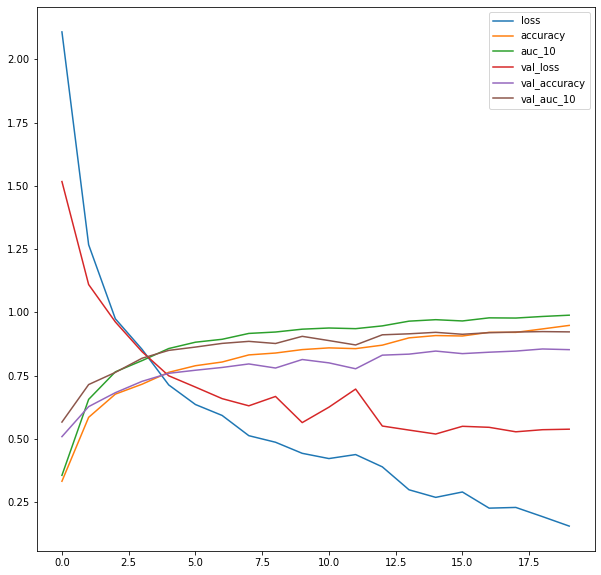

In [ ]:
#plotting classification metrics on training and testing sets
pd.DataFrame(history.history).plot(figsize=(10, 10))

**SAVING MODEL**

In [ ]:
#extacting model architecture in JSON format
json_model = model.to_json()

In [ ]:
#saving model architecture into JSON file
with open("./drive/My Drive/model_architecture.json", 'w') as json_file:
  json_file.write(json_model)

In [ ]:
#saving model weights
model.save_weights('./drive/My Drive/model_weights.h5')

**MODEL EVALUTION**

In [ ]:
#predicting test set
Y_pred = model.predict(X_test_padded)

In [ ]:
#getting top prediction for each observation
Y_pred2 = [np.argmax(x) for x in Y_pred]
Y_test2 = [np.argmax(x) for x in Y_test]
labels = list(encoder.classes_)

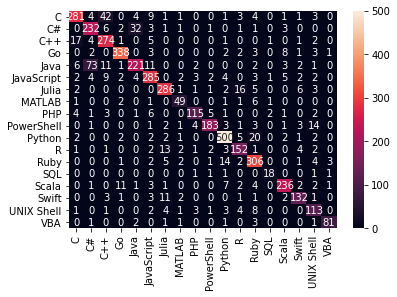

In [ ]:
#plotting confusion matrix
sns.heatmap(confusion_matrix(Y_test2, Y_pred2), annot=True, fmt='g', xticklabels=labels, yticklabels=labels)